In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader, Dataset
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout
import keras_tuner as kt
from tqdm import tqdm

figsize = (16,4)
plt.rcParams['figure.figsize'] = figsize
pd.set_option('display.float_format', lambda x: '%.2f' % x)b

df = pd.read_parquet("/kaggle/input/stock-news/stock-news-cleaned.parquet")

df = df[['date', 'stock', 'cleaned_title', 'cleaned_summary']]
df.columns = ['date', 'stock', 'title', 'summary']

if torch. cuda. is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
                          
print(f"Using {device}.")

2024-07-12 01:18:00.819736: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 01:18:00.819795: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 01:18:00.821695: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using cuda.


In [41]:
stocks = pd.read_parquet('/kaggle/input/stock-history/stock-history-features.parquet')
stocks

,close,stock,day_of_week,day,month,year,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14
0,383.20,TSLA,1,4,1,2022,391.56,11.83,391.56,11.83
1,362.71,TSLA,2,5,1,2022,381.94,18.64,381.94,18.64
2,354.90,TSLA,3,6,1,2022,375.18,20.36,375.18,20.36
3,342.32,TSLA,4,7,1,2022,368.61,22.95,368.61,22.95
4,352.71,TSLA,0,10,1,2022,365.96,21.53,365.96,21.53
...,...,...,...,...,...,...,...,...,...,...
1876,186.86,GOOG,3,27,6,2024,181.86,4.11,179.79,3.64
1877,183.42,GOOG,4,28,6,2024,182.86,3.36,180.34,3.57
1878,184.49,GOOG,0,1,7,2024,183.82,2.49,180.90,3.56
1879,186.61,GOOG,1,2,7,2024,184.73,2.10,181.50,3.77


## Tokenization and Sentiment Analysis

In [4]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device)

In [5]:
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

def collate_fn(batch):
    return tokenizer(batch, padding=True, truncation=True, return_tensors="pt")

def sentiment_analyzer(texts, batch_size=64):
    dataset = TextDataset(texts)
    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)
    
    all_scores = []

    for batch in tqdm(dataloader, desc="Processing batches"):
        batch = {k: v.to('cuda') for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        scores = outputs.logits.softmax(dim=-1).detach().cpu().numpy()
        all_scores.extend(scores)
    
    all_scores = np.vstack(all_scores)

    return all_scores

In [6]:
titles = df['title'].to_list()
title_sentiments = sentiment_analyzer(titles)

Processing batches: 100%|██████████| 2367/2367 [06:15<00:00,  6.31it/s]


In [18]:
summaries = df['summary'].to_list()
summary_sentiments = sentiment_analyzer(summaries)

Processing batches: 100%|██████████| 2367/2367 [08:18<00:00,  4.75it/s]


In [28]:
sentiment_columns = ['title_pos', 'title_neg', 'title_neu', 'summary_pos', 'summary_neg', 'summary_neu']
df[sentiment_columns[:3]] = title_sentiments
df[sentiment_columns[3:]] = summary_sentiments

df

,date,stock,title,summary,title_pos,title_neg,title_neu,summary_pos,summary_neg,summary_neu
0,2022-03-01 08:00:00,TSLA,tesla rival slashes 2022 production outlook lu...,lucid stock sinks tesla rival slashes 2022 pro...,0.01,0.95,0.03,0.01,0.93,0.06
1,2022-03-01 08:00:00,TSLA,nasdaq move positive territory broad market bo...,live update dow tumble russia threaten west cnn,0.66,0.10,0.24,0.04,0.24,0.73
2,2022-03-01 11:30:14,TSLA,byd use baidu autonomous driving technology ta...,byd china big electric vehicle ev builder sale...,0.09,0.01,0.90,0.74,0.01,0.25
3,2022-03-01 16:30:19,TSLA,chinese electric car maker february sale dent ...,china big maker smart electric vehicle evs rep...,0.14,0.03,0.83,0.20,0.79,0.02
4,2022-03-02 08:00:00,TSLA,box stock jumps fourth quarter result outlook ...,box stock jumps earnings beat estimates invest...,0.01,0.96,0.02,0.45,0.15,0.41
...,...,...,...,...,...,...,...,...,...,...
152934,2024-07-03 22:02:00,GOOG,luxury rival join force amazon get action,saks neiman marcus tie shield giant like lvmh ...,0.22,0.02,0.76,0.08,0.02,0.91
152935,2024-07-03 22:14:00,GOOG,influencer talent firm night lay leader team a...,night shuts studio influencer led movie tv pro...,0.08,0.03,0.89,0.01,0.84,0.15
152936,2024-07-03 22:14:27,GOOG,correction united states mint open sales 2024 ...,washington july 03 2024 globe newswire release...,0.09,0.05,0.87,0.07,0.03,0.90
152937,2024-07-03 22:30:49,GOOG,today nyt strands hint spangram answers thursd...,look wednesday strands hint spangram answer fi...,0.02,0.05,0.93,0.03,0.04,0.92


In [29]:
news_sentiments = df.groupby('date')[sentiment_columns].mean().reset_index()
news_sentiments

,date,title_pos,title_neg,title_neu,summary_pos,summary_neg,summary_neu
0,2022-03-01 08:00:00,0.17,0.36,0.47,0.03,0.43,0.54
1,2022-03-01 11:30:14,0.09,0.01,0.90,0.74,0.01,0.25
2,2022-03-01 16:30:19,0.14,0.03,0.83,0.20,0.79,0.02
3,2022-03-02 02:00:13,0.03,0.65,0.33,0.02,0.86,0.12
4,2022-03-02 04:17:00,0.07,0.04,0.89,0.07,0.02,0.91
...,...,...,...,...,...,...,...
124595,2024-07-03 22:14:00,0.08,0.03,0.89,0.01,0.84,0.15
124596,2024-07-03 22:14:27,0.09,0.05,0.87,0.07,0.03,0.90
124597,2024-07-03 22:30:49,0.02,0.05,0.93,0.03,0.04,0.92
124598,2024-07-03 22:48:00,0.07,0.02,0.92,0.10,0.01,0.88


## Visualization

In [66]:
index = 100
test = df.set_index('date')[:index]
closing_prices = stocks['close'][:index]
price_changes = closing_prices.diff().fillna(0)


scaler = MinMaxScaler(feature_range=(-1,1))
scaled_changes = scaler.fit_transform(price_changes.values.reshape(-1,1))
price_changes = pd.DataFrame(scaled_changes, columns=['close'])

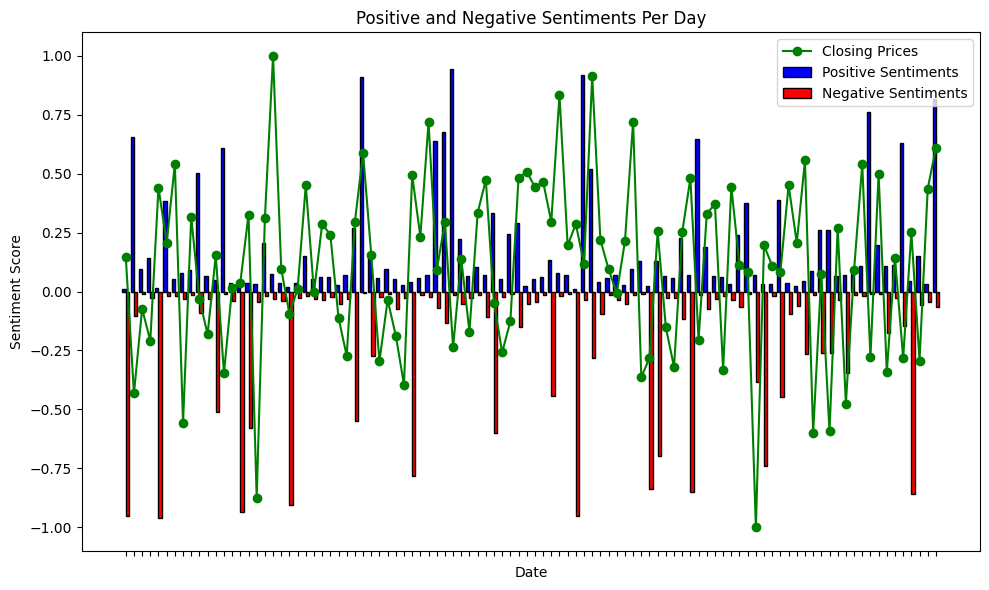

In [69]:
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.4
positions = range(len(test))
ax.bar([pos - bar_width/2 for pos in positions], test['title_pos'], width=bar_width, label='Positive Sentiments', color='b', edgecolor='black')
ax.bar([pos + bar_width/2 for pos in positions], -test['title_neg'], width=bar_width, label='Negative Sentiments', color='r', edgecolor='black')

ax.plot(price_changes.index, price_changes['close'], 'g-o', label='Closing Prices')

ax.set_xlabel('Date')
ax.set_ylabel('Sentiment Score')
ax.set_title('Positive and Negative Sentiments Per Day')
ax.legend()
ax.set_xticks(positions)
ax.set_xticklabels('')
plt.tight_layout()

# Show plot
plt.show()

## Save Data

In [32]:
df.to_parquet('news_sentiments.parquet')
news_sentiments.to_parquet('news-sentiment-features.parquet')